# # Set 3 — Q9
**Task:** Perform frequency-domain filtering **with** and **without** zero **padding**, and compare the results.


In [1]:
# %%
# --- Imports & Config ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === User: set your image path here (grayscale is fine; color will be converted) ===
img_path = "image.jpg" 
force_size = (256, 256)   # set to None to keep original size

# Filtering params
filter_type = "butterworth"  # "ideal" | "butterworth" | "gaussian"
mode        = "lowpass"      # "lowpass" | "highpass"
D0          = 35             # cutoff radius (pixels)
order_n     = 2              # Butterworth order (ignored for ideal/gaussian)
pad_factor  = 2              # e.g., 2 = pad to (2H, 2W)

out_dir = Path("./outputs_q9")
out_dir.mkdir(parents=True, exist_ok=True)

def imshow(ax, img, title="", cmap=None):
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

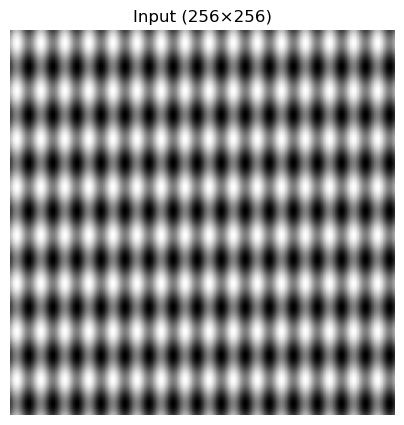

True

In [2]:
# %%
# --- Load grayscale image ---
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    # Fallback: make a textured synthetic image
    h, w = 256, 256
    yy, xx = np.mgrid[0:h, 0:w]
    img = (127 + 50*np.sin(2*np.pi*xx/16.0) + 50*np.sin(2*np.pi*yy/32.0)).astype(np.uint8)

if force_size is not None:
    img = cv2.resize(img, force_size, interpolation=cv2.INTER_AREA)

H, W = img.shape[:2]
plt.figure(figsize=(5,5)); plt.imshow(img, cmap="gray"); plt.title(f"Input ({W}×{H})"); plt.axis("off"); plt.show()
cv2.imwrite(str(out_dir / "q9_input.png"), img)

In [3]:
# %%
# --- Helpers: DFT, spectrum visualization, and circular filters ---
def dft2(img):
    F = np.fft.fft2(img.astype(np.float32))
    return F

def idft2(F):
    out = np.fft.ifft2(F)
    return np.real(out)

def spectrum(F):
    return np.log(1 + np.abs(np.fft.fftshift(F)))

def make_distance_grid(h, w):
    u = np.arange(w) - w//2
    v = np.arange(h) - h//2
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    return D

def make_filter(h, w, ftype="ideal", mode="lowpass", D0=30, n=2):
    D = make_distance_grid(h, w)
    eps = 1e-8
    if ftype == "ideal":
        H = (D <= D0).astype(np.float32)
    elif ftype == "butterworth":
        H = 1.0 / (1.0 + (D / max(D0, eps))**(2*n))
    elif ftype == "gaussian":
        H = np.exp(-(D**2) / (2*(max(D0, eps)**2)))
    else:
        raise ValueError("Unknown filter type")

    if mode == "lowpass":
        return np.fft.ifftshift(H)
    elif mode == "highpass":
        return np.fft.ifftshift(1.0 - H)
    else:
        raise ValueError("Unknown mode")

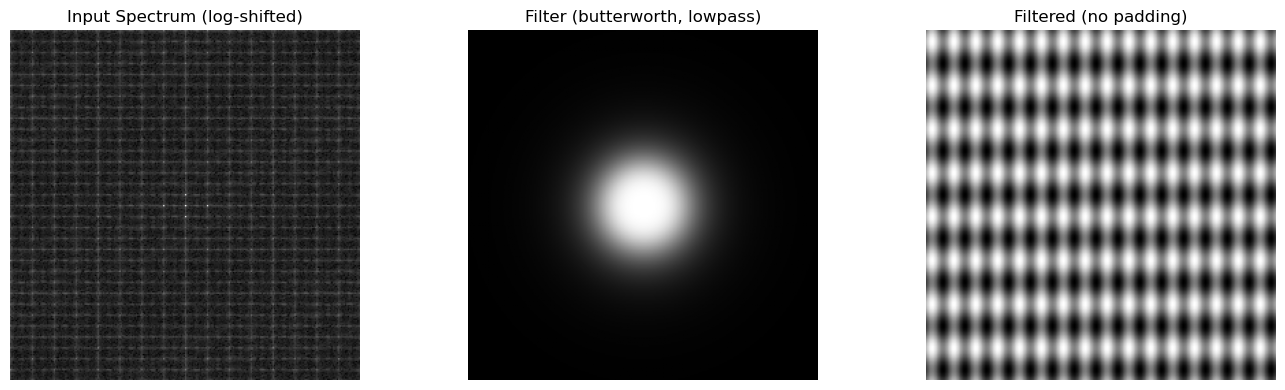

True

In [4]:
# %%
# --- Filtering WITHOUT padding ---
F = dft2(img)
H = make_filter(H, W, ftype=filter_type, mode=mode, D0=D0, n=order_n)
G = F * H
g = idft2(G)
g_clip = np.clip(g, 0, 255).astype(np.uint8)

# Visualize
fig, axs = plt.subplots(1,3, figsize=(14,4))
imshow(axs[0], spectrum(F), "Input Spectrum (log-shifted)", cmap="gray")
imshow(axs[1], np.fft.fftshift(H), f"Filter ({filter_type}, {mode})", cmap="gray")
imshow(axs[2], g_clip, "Filtered (no padding)", cmap="gray")
plt.tight_layout(); plt.show()

cv2.imwrite(str(out_dir / "q9_no_padding_filtered.png"), g_clip)

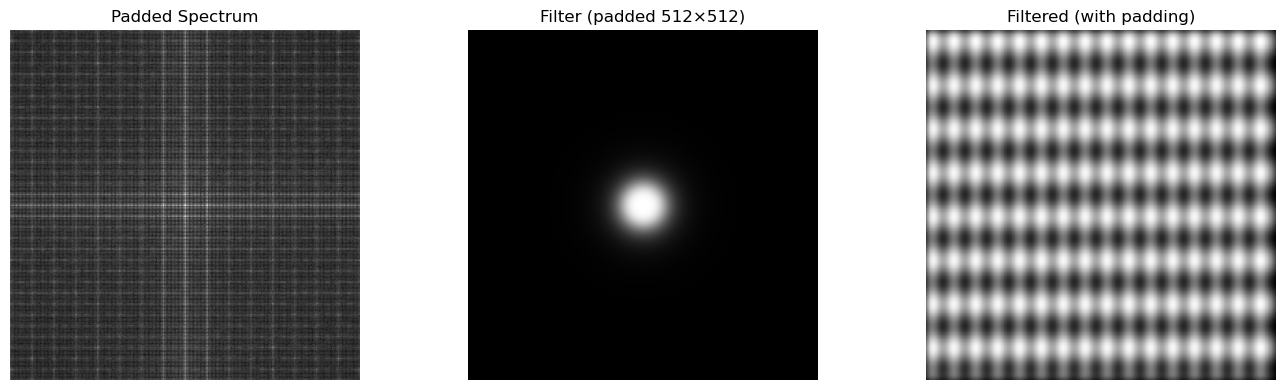

True

In [6]:
# %%
# --- Filtering WITH zero padding (fixed) ---
H_img, W_img = img.shape[:2]               # original image size
pad_h = int(H_img * pad_factor)            # ensure integers
pad_w = int(W_img * pad_factor)

# Center the image in a zero-padded canvas
padded = np.zeros((pad_h, pad_w), dtype=np.float32)
y0 = (pad_h - H_img) // 2
x0 = (pad_w - W_img) // 2
padded[y0:y0+H_img, x0:x0+W_img] = img.astype(np.float32)

# DFT on padded image
Fp = dft2(padded)

# Build filter for padded size (use a different name to avoid shadowing)
Hpad = make_filter(pad_h, pad_w, ftype=filter_type, mode=mode, D0=D0, n=order_n)

# Apply in frequency domain and invert
Gp = Fp * Hpad
gp = idft2(Gp)

# Crop back to original size
gpc = gp[y0:y0+H_img, x0:x0+W_img]
gpc_clip = np.clip(gpc, 0, 255).astype(np.uint8)

# Visualize
fig, axs = plt.subplots(1,3, figsize=(14,4))
imshow(axs[0], spectrum(Fp), "Padded Spectrum", cmap="gray")
imshow(axs[1], np.fft.fftshift(Hpad), f"Filter (padded {pad_h}×{pad_w})", cmap="gray")
imshow(axs[2], gpc_clip, "Filtered (with padding)", cmap="gray")
plt.tight_layout(); plt.show()

# Save
cv2.imwrite(str(out_dir / "q9_with_padding_filtered.png"), gpc_clip)


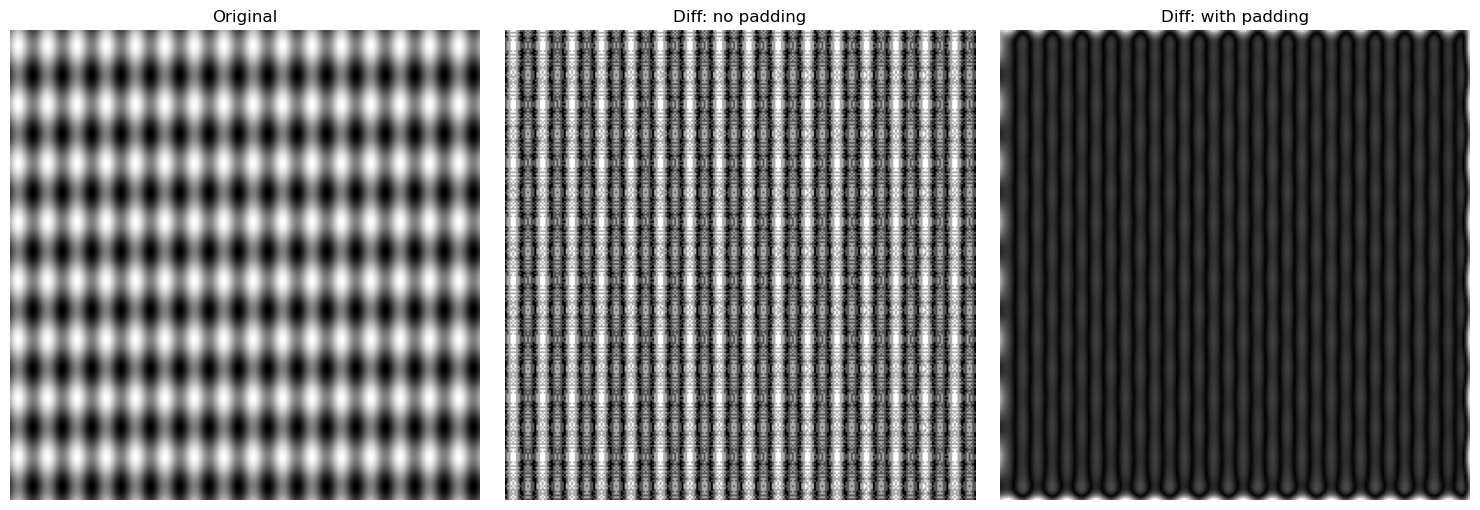

PSNR(Original vs No-Pad)  : 43.76 dB
PSNR(Original vs With-Pad): 23.56 dB
Saved outputs to: D:\git\Image and Video Processing\Lab_3\QUESTION9\outputs_q9


In [7]:
# %%
# --- Side-by-side comparison & simple metrics ---
def psnr(a, b):
    a = a.astype(np.float32); b = b.astype(np.float32)
    mse = np.mean((a - b)**2)
    if mse <= 1e-12: return 99.0
    PIX = 255.0
    return 20*np.log10(PIX / np.sqrt(mse))

fig, axs = plt.subplots(1,3, figsize=(15,5))
imshow(axs[0], img, "Original", cmap="gray")
imshow(axs[1], cv2.normalize(cv2.absdiff(img, g_clip), None, 0, 255, cv2.NORM_MINMAX), "Diff: no padding", cmap="gray")
imshow(axs[2], cv2.normalize(cv2.absdiff(img, gpc_clip), None, 0, 255, cv2.NORM_MINMAX), "Diff: with padding", cmap="gray")
plt.tight_layout(); plt.show()

print(f"PSNR(Original vs No-Pad)  : {psnr(img, g_clip):.2f} dB")
print(f"PSNR(Original vs With-Pad): {psnr(img, gpc_clip):.2f} dB")

cv2.imwrite(str(out_dir / "q9_diff_no_padding.png"),
            cv2.normalize(cv2.absdiff(img, g_clip), None, 0, 255, cv2.NORM_MINMAX))
cv2.imwrite(str(out_dir / "q9_diff_with_padding.png"),
            cv2.normalize(cv2.absdiff(img, gpc_clip), None, 0, 255, cv2.NORM_MINMAX))
print("Saved outputs to:", out_dir.resolve())